In [1]:
import os
import h5py
import numpy as np
import json
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import Image, display, clear_output
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1

In [3]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_train = model.predict(generator, nb_train_samples//batch_size)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir, target_size=(img_width,img_height), batch_size=batch_size, class_mode=None, shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples//batch_size)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [4]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_acc'])
    print('epoch:', best_epoch+1, ', val_acc:', model_hist['val_acc'][best_epoch], ', val_loss:', model_hist['val_loss'][best_epoch])

In [5]:

def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist['acc'], label='Training')
    axes[0].plot(range(stop), hist['val_acc'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
    
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout();
    
    print("Best Model:")
    print_best_model_results(hist)

In [6]:
def train_categorical_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))
    train_labels = to_categorical(train_labels,3)
    
    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))
    validation_labels = to_categorical(validation_labels,3)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True,mode='auto')
    
    fit = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(validation_data,validation_labels), callbacks=[checkpoint])
    model.save_weights(top_model_weights_path)  
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model,fit.history

In [7]:
def finetune_categorical_model():
    
    base_model = VGG16(weights='imagenet',include_top= False,input_shape=(256,256,3))
    print("Model loaded.")
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))
    top_model.save_weights(top_model_weights_path)  
    top_model.load_weights(top_model_weights_path)
    
    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.00001, momentum=0.9), metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
    
    fit = model.fit(train_generator, steps_per_epoch=nb_train_samples//batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nb_validation_samples//batch_size, verbose=1, callbacks=[checkpoint])
    top_model.save_weights(fine_tuned_model_path)
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
        
    return model, fit.history

In [8]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(directory, target_size=(img_height,img_width), batch_size=batch_size, class_mode='categorical', shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    
    pred_labels = [0 if i<0.5 else 1 for i in predictions]
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

In [9]:
location = 'data3'
top_model_weights_path = location+'/top_model_weights.h5'
fine_tuned_model_path = location+'/ft_model.h5'
model1 = location+'/bottleneck_fc_model.h5'
train_data_dir = location+'/training'
validation_data_dir = location+'/validation'
train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = 1824
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = 448

img_width, img_height = 256,256
epochs = 2
batch_size = 16

In [10]:
save_bottleneck_features()

Found 1824 images belonging to 3 classes.
114/114 [==============================] - 182s 2s/step
Found 448 images belonging to 3 classes.
28/28 [==============================] - 51s 2s/step


In [11]:
d3_model, d3_history = train_categorical_model()

Epoch 1/2
114/114 [==============================] - 7s 58ms/step - loss: 2.1417 - accuracy: 0.5104 - val_loss: 0.6946 - val_accuracy: 0.5067
Epoch 2/2
114/114 [==============================] - 6s 52ms/step - loss: 0.7872 - accuracy: 0.5126 - val_loss: 0.7966 - val_accuracy: 0.5000


In [15]:
ft_model, ft_history = finetune_categorical_model()

Model loaded.
Found 1824 images belonging to 3 classes.
Found 448 images belonging to 3 classes.
Epoch 1/2
114/114 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.5318WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 199s 2s/step - loss: 0.9682 - accuracy: 0.5318 - val_loss: 1.2085 - val_accuracy: 0.1875
Epoch 2/2
114/114 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.4885WARNING:tensorflow:Can save best model only with val_acc available, skipping.


114/114 [==============================] - 237s 2s/step - loss: 1.0387 - accuracy: 0.4885 - val_loss: 1.2085 - val_accuracy: 0.1875


In [16]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1] +
                             [2] * validation_samples[2])

In [17]:
def pipe31(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256,256))
    x = img_to_array(img)
    x = x.reshape((1,)+x.shape)/255
    pred = model.predict(x)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

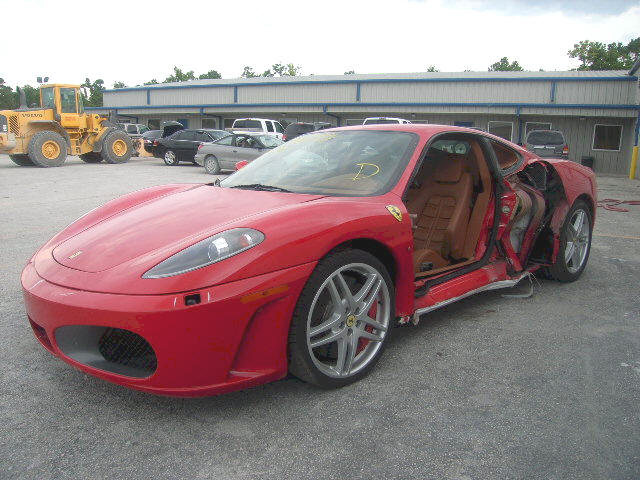

In [18]:
Image('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg')

In [19]:
pipe31('http://repairablecars-forsale.com/photos/Exotic_Wrecked_Cars_F430_Spider_Red_Ferrari.jpg', ft_model)

1/1 [==============================] - 0s 187ms/step
Validating location of damage....Result: Rear
Severity assessment complete.


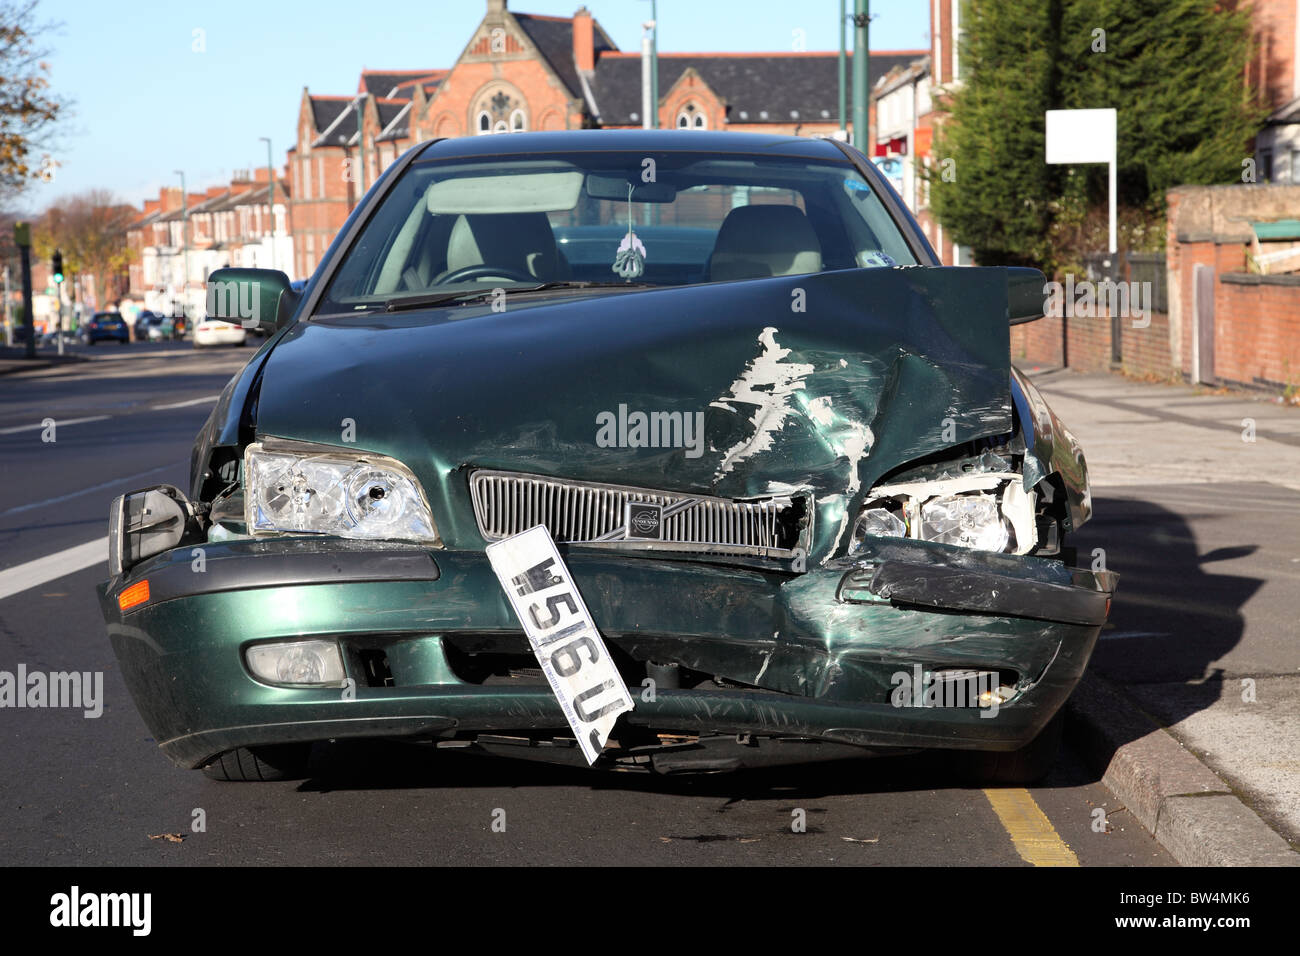

In [20]:
Image('https://c8.alamy.com/comp/BW4MK6/an-accident-damaged-car-on-a-uk-street-BW4MK6.jpg')

In [21]:
pipe31('https://c8.alamy.com/comp/BW4MK6/an-accident-damaged-car-on-a-uk-street-BW4MK6.jpg',ft_model)

1/1 [==============================] - 0s 113ms/step
Validating location of damage....Result: Rear
Severity assessment complete.


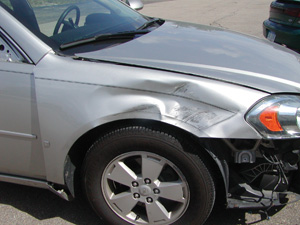

In [22]:
Image('https://s19525.pcdn.co/wp-content/uploads/2011/09/92249TECHImageD_00000046376.jpg')

In [23]:
pipe31('https://s19525.pcdn.co/wp-content/uploads/2011/09/92249TECHImageD_00000046376.jpg',ft_model)

1/1 [==============================] - 0s 116ms/step
Validating location of damage....Result: Rear
Severity assessment complete.


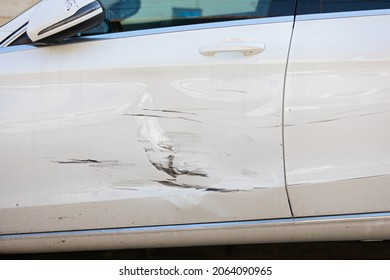

In [24]:
Image('https://www.shutterstock.com/image-photo/close-picture-damage-on-white-260nw-2064090965.jpg')

In [25]:
pipe31('https://www.shutterstock.com/image-photo/close-picture-damage-on-white-260nw-2064090965.jpg',ft_model)

1/1 [==============================] - 0s 139ms/step
Validating location of damage....Result: Front
Severity assessment complete.
